In [9]:
from __future__ import print_function
import numpy as np
import glob
import pandas as pd
from random import shuffle,seed

seed(2017)
np.random.seed(2017)

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator
import cv2
WIDTH  = 86
HEIGHT = 64

batch_size = 16
num_classes = 3
epochs = 20


print( tensorflow.__version__,keras.__version__)

1.3.0 2.0.8


In [10]:
def build_train_set():
    
    images =  glob.glob("/disk/projects/selfdriving/shared/img4/*.jpg") 
    dataset = []
    for file in images:
        
        label = int( file.split("_")[-1].split(".")[0] )
        if label==4:
            continue
        #print(label)
        img = cv2.imread(file)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize( img, (WIDTH, HEIGHT))
        
        
        ## flip image for data augmentation
        img2 = cv2.flip( img.copy(), 1 )
        #plt.imshow(img2)
        
            
        dataset.append( (np.array(img), label))
        dataset.append( (np.array(img2), label))

    shuffle(dataset)
        
    return np.array(dataset)

In [11]:
dataset = build_train_set()

len(dataset)

1010

In [12]:
r = np.random.rand( dataset.shape[0])
train = dataset[r<.8]
test = dataset[r>=.8]

In [13]:
train.shape, test.shape
x_train = np.array([ img for img in train[:,0]])
y_train = train[:,1]

x_test = np.array([ img for img in test[:,0]])
y_test = test[:,1]

In [14]:
# input image dimensions
img_rows, img_cols = HEIGHT, WIDTH


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks =[es]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (807, 64, 86, 3)
807 train samples
203 test samples
Train on 807 samples, validate on 203 samples
Epoch 1/20
807/807 [==============================] - 28s - loss: 0.8704 - acc: 0.6667 - val_loss: 0.5876 - val_acc: 0.6995
Epoch 2/20
807/807 [==============================] - 29s - loss: 0.5743 - acc: 0.7621 - val_loss: 0.3564 - val_acc: 0.8571
Epoch 3/20
807/807 [==============================] - 29s - loss: 0.3566 - acc: 0.8575 - val_loss: 0.2077 - val_acc: 0.9163
Epoch 4/20
807/807 [==============================] - 30s - loss: 0.2074 - acc: 0.9133 - val_loss: 0.1198 - val_acc: 0.9360
Epoch 5/20
807/807 [==============================] - 30s - loss: 0.1351 - acc: 0.9467 - val_loss: 0.1155 - val_acc: 0.9557
Epoch 6/20
807/807 [==============================] - 30s - loss: 0.0984 - acc: 0.9653 - val_loss: 0.1541 - val_acc: 0.9507
Epoch 7/20
807/807 [==============================] - 31s - loss: 0.0767 - acc: 0.9715 - val_loss: 0.0827 - val_acc: 0.9803
Epoch 8/20
807/807 

In [15]:
model.save("/disk/projects/selfdriving/shared/model/model_5_keep_aspect_ratio.hd5")

In [17]:
WIDTH, HEIGHT

(86, 64)

In [26]:
ret = model.predict( x_train[123].reshape( 1, HEIGHT, WIDTH, 3) )

In [27]:
ret

array([[  9.99996424e-01,   3.51245853e-06,   6.27214618e-08]], dtype=float32)

In [28]:
np.argmax(ret)

0

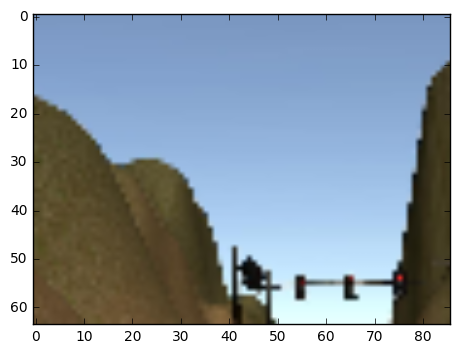

In [29]:
plt.imshow( x_train[123])

In [30]:
del model

from keras.models import load_model
model = load_model("/disk/projects/selfdriving/shared/model/model_5_keep_aspect_ratio.hd5")

In [31]:
%time ret = model.predict( x_train[8].reshape( 1, HEIGHT, WIDTH, 3) )

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 84.6 ms


In [32]:
ret, np.argmax(ret)

(array([[  2.62193171e-05,   9.99289751e-01,   6.84060855e-04]], dtype=float32),
 1)